This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Deep learning for timeseries

## Different kinds of timeseries tasks

## A temperature-forecasting example

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-11-05 18:34:31--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.66.40, 16.182.73.24, 52.217.137.48, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.66.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  7.05MB/s    in 1.8s    

2023-11-05 18:34:34 (7.05 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset**

In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

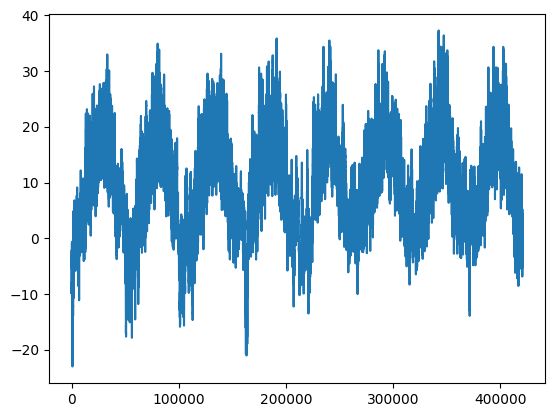

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

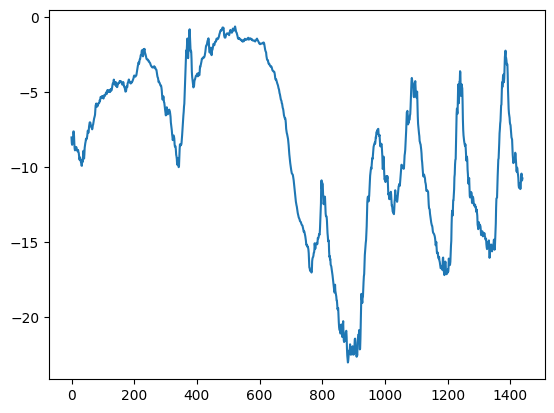

In [5]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [8]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [9]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [10]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [11]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - ETA: 0s - loss: 13.9422 - mae: 2.8979

ValueError: ignored

run without callback

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:


inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

model.save("jena_dense.keras")

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 14s 17ms/step - loss: 13.0793 - mae: 2.8050 - val_loss: 10.9378 - val_mae: 2.6289
Epoch 2/10
819/819 [==============================] - 13s 16ms/step - loss: 9.5250 - mae: 2.4251 - val_loss: 12.7215 - val_mae: 2.8437
Epoch 3/10
819/819 [==============================] - 14s 16ms/step - loss: 8.7160 - mae: 2.3217 - val_loss: 11.2592 - val_mae: 2.6440
Epoch 4/10
819/819 [==============================] - 14s 16ms/step - loss: 8.2084 - mae: 2.2556 - val_loss: 10.2669 - val_mae: 2.5360
Epoch 5/10
819/819 [==============================] - 13s 16ms/step - loss: 7.8714 - mae: 2.2104 - val_loss: 11.4602 - val_mae: 2.6886
Epoch 6/10
819/819 [==============================] - 14s 16ms/step - loss: 7.6243 - mae: 2.1759 - val_loss: 12.6448 - val_mae: 2.8151
Epoch 7/10
819/819 [==============================] - 14s 16ms/step - loss: 7.4328 - mae: 2.1497 - val_loss: 11.1839 - val_mae: 2.6495
Epoch 8/10
819/819 [==============================] - 

**Plotting results**

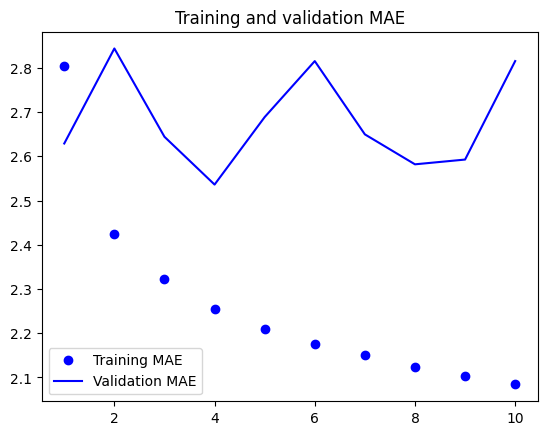

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

model.save("jena_conv.keras")

model = keras.models.load_model("jena_conv.keras")

test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")

Epoch 1/10
819/819 [==============================] - 16s 18ms/step - loss: 22.8735 - mae: 3.7013 - val_loss: 18.0778 - val_mae: 3.3409
Epoch 2/10
819/819 [==============================] - 14s 17ms/step - loss: 15.2298 - mae: 3.0948 - val_loss: 18.5747 - val_mae: 3.3762
Epoch 3/10
819/819 [==============================] - 14s 17ms/step - loss: 13.7999 - mae: 2.9438 - val_loss: 16.1895 - val_mae: 3.2114
Epoch 4/10
819/819 [==============================] - 14s 17ms/step - loss: 12.9556 - mae: 2.8516 - val_loss: 16.7030 - val_mae: 3.1470
Epoch 5/10
819/819 [==============================] - 14s 17ms/step - loss: 12.3478 - mae: 2.7833 - val_loss: 15.8270 - val_mae: 3.0810
Epoch 6/10
819/819 [==============================] - 14s 18ms/step - loss: 11.9559 - mae: 2.7390 - val_loss: 15.8575 - val_mae: 3.0808
Epoch 7/10
819/819 [==============================] - 14s 17ms/step - loss: 11.5961 - mae: 2.6965 - val_loss: 16.5091 - val_mae: 3.1195
Epoch 8/10
819/819 [============================

### A first recurrent baseline

**A simple LSTM-based model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

model.save("jena_lstm.keras")

model = keras.models.load_model("jena_lstm.keras")

test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")

Epoch 1/10
819/819 [==============================] - 18s 18ms/step - loss: 43.3001 - mae: 4.7783 - val_loss: 12.3801 - val_mae: 2.6589
Epoch 2/10
819/819 [==============================] - 14s 18ms/step - loss: 10.8476 - mae: 2.5555 - val_loss: 9.6705 - val_mae: 2.4010
Epoch 3/10
819/819 [==============================] - 14s 18ms/step - loss: 9.5245 - mae: 2.4024 - val_loss: 9.8732 - val_mae: 2.4272
Epoch 4/10
819/819 [==============================] - 15s 18ms/step - loss: 9.1553 - mae: 2.3554 - val_loss: 10.0124 - val_mae: 2.4475
Epoch 5/10
819/819 [==============================] - 15s 18ms/step - loss: 8.8999 - mae: 2.3206 - val_loss: 9.9859 - val_mae: 2.4435
Epoch 6/10
819/819 [==============================] - 15s 18ms/step - loss: 8.6843 - mae: 2.2936 - val_loss: 10.5531 - val_mae: 2.5099
Epoch 7/10
819/819 [==============================] - 14s 17ms/step - loss: 8.4909 - mae: 2.2675 - val_loss: 9.9936 - val_mae: 2.4544
Epoch 8/10
819/819 [==============================] - 14s

## Understanding recurrent neural networks

**NumPy implementation of a simple RNN**

In [13]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [14]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

In [15]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns its full output sequence**

In [16]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking RNN layers**

In [17]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)  # You can adjust dropout rates here if needed.
x = layers.Dropout(0.5)(x)  # Adjust dropout rates as needed.
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset
)

model.save("jena_lstm_dropout.keras")

Epoch 1/50
819/819 [==============================] - 255s 308ms/step - loss: 27.8987 - mae: 3.8970 - val_loss: 10.0518 - val_mae: 2.4674
Epoch 2/50
819/819 [==============================] - 250s 305ms/step - loss: 14.8662 - mae: 2.9938 - val_loss: 10.2544 - val_mae: 2.4859
Epoch 3/50
819/819 [==============================] - 250s 306ms/step - loss: 14.0331 - mae: 2.9055 - val_loss: 9.5216 - val_mae: 2.3857
Epoch 4/50
819/819 [==============================] - 251s 306ms/step - loss: 13.2953 - mae: 2.8283 - val_loss: 9.2849 - val_mae: 2.3573
Epoch 5/50
819/819 [==============================] - 251s 306ms/step - loss: 12.8571 - mae: 2.7791 - val_loss: 9.6205 - val_mae: 2.3974
Epoch 6/50
819/819 [==============================] - 250s 305ms/step - loss: 12.5158 - mae: 2.7457 - val_loss: 9.8754 - val_mae: 2.4417
Epoch 7/50
819/819 [==============================] - 250s 305ms/step - loss: 12.1805 - mae: 2.7091 - val_loss: 9.2894 - val_mae: 2.3519
Epoch 8/50
819/819 [===================

In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset
)

model.save("jena_stacked_gru_dropout.keras")


model = keras.models.load_model("jena_stacked_gru_dropout.keras")

test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")

Epoch 1/50
819/819 [==============================] - 491s 589ms/step - loss: 24.3694 - mae: 3.6524 - val_loss: 9.4538 - val_mae: 2.3836
Epoch 2/50
819/819 [==============================] - 477s 583ms/step - loss: 14.0290 - mae: 2.9012 - val_loss: 9.3778 - val_mae: 2.3788
Epoch 3/50
819/819 [==============================] - 476s 581ms/step - loss: 13.3217 - mae: 2.8293 - val_loss: 9.2452 - val_mae: 2.3603
Epoch 4/50
819/819 [==============================] - 474s 579ms/step - loss: 12.7727 - mae: 2.7681 - val_loss: 9.2690 - val_mae: 2.3631
Epoch 5/50
819/819 [==============================] - 476s 581ms/step - loss: 12.3418 - mae: 2.7242 - val_loss: 9.4738 - val_mae: 2.3875
Epoch 6/50
819/819 [==============================] - 475s 580ms/step - loss: 11.8122 - mae: 2.6668 - val_loss: 9.3680 - val_mae: 2.3591
Epoch 7/50
819/819 [==============================] - 468s 571ms/step - loss: 11.4859 - mae: 2.6292 - val_loss: 9.2616 - val_mae: 2.3487
Epoch 8/50
819/819 [=====================

405/405 [==============================] - 26s 63ms/step - loss: 13.3474 - mae: 2.9082
Test MAE: 2.91


In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(64, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(64, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset
)

model.save("jena_stacked_gru_dropout.keras")

model = keras.models.load_model("jena_stacked_gru_dropout.keras")


test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")

Epoch 1/20
819/819 [==============================] - 480s 573ms/step - loss: 16.6665 - mae: 3.0875 - val_loss: 8.8653 - val_mae: 2.3056
Epoch 2/20
819/819 [==============================] - 464s 567ms/step - loss: 11.6469 - mae: 2.6623 - val_loss: 8.9357 - val_mae: 2.3198
Epoch 3/20
819/819 [==============================] - 462s 564ms/step - loss: 10.8201 - mae: 2.5644 - val_loss: 9.2472 - val_mae: 2.3599
Epoch 4/20
819/819 [==============================] - 461s 563ms/step - loss: 10.0408 - mae: 2.4764 - val_loss: 9.6178 - val_mae: 2.4317
Epoch 5/20
819/819 [==============================] - 457s 558ms/step - loss: 9.2668 - mae: 2.3757 - val_loss: 10.1981 - val_mae: 2.5039
Epoch 6/20
819/819 [==============================] - 457s 557ms/step - loss: 8.5872 - mae: 2.2858 - val_loss: 10.1384 - val_mae: 2.5012
Epoch 7/20
819/819 [==============================] - 456s 557ms/step - loss: 8.0307 - mae: 2.2089 - val_loss: 11.0240 - val_mae: 2.5945
Epoch 8/20
819/819 [=====================

405/405 [==============================] - 26s 62ms/step - loss: 12.5229 - mae: 2.8101
Test MAE: 2.81


In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset
)

model.save("jena_stacked_gru_dropout.keras")

model = keras.models.load_model("jena_stacked_gru_dropout.keras")


test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")

Epoch 1/20
819/819 [==============================] - 499s 604ms/step - loss: 25.5545 - mae: 3.7350 - val_loss: 9.3223 - val_mae: 2.3634
Epoch 2/20
819/819 [==============================] - 494s 603ms/step - loss: 13.7659 - mae: 2.8768 - val_loss: 9.3108 - val_mae: 2.3601
Epoch 3/20
819/819 [==============================] - 498s 608ms/step - loss: 12.4527 - mae: 2.7297 - val_loss: 10.2585 - val_mae: 2.4746
Epoch 4/20
819/819 [==============================] - 502s 612ms/step - loss: 11.5299 - mae: 2.6248 - val_loss: 10.1977 - val_mae: 2.4878
Epoch 5/20
819/819 [==============================] - 507s 618ms/step - loss: 10.8124 - mae: 2.5356 - val_loss: 10.4189 - val_mae: 2.5203
Epoch 6/20
819/819 [==============================] - 502s 613ms/step - loss: 10.1952 - mae: 2.4640 - val_loss: 10.6811 - val_mae: 2.5627
Epoch 7/20
819/819 [==============================] - 510s 622ms/step - loss: 9.7918 - mae: 2.4138 - val_loss: 11.2789 - val_mae: 2.6372
Epoch 8/20
819/819 [=================

405/405 [==============================] - 28s 67ms/step - loss: 13.4181 - mae: 2.8834
Test MAE: 2.88


In [18]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.LSTM(64, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(64, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset
)

model.save("jena_stacked_gru_dropout.keras")

model = keras.models.load_model("jena_stacked_gru_dropout.keras")


test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")

Epoch 1/20
819/819 [==============================] - 490s 586ms/step - loss: 17.0328 - mae: 3.0984 - val_loss: 10.2654 - val_mae: 2.4845
Epoch 2/20
819/819 [==============================] - 473s 578ms/step - loss: 10.5438 - mae: 2.5260 - val_loss: 10.5142 - val_mae: 2.5157
Epoch 3/20
819/819 [==============================] - 471s 574ms/step - loss: 9.0005 - mae: 2.3270 - val_loss: 11.1819 - val_mae: 2.6170
Epoch 4/20
819/819 [==============================] - 469s 573ms/step - loss: 7.8124 - mae: 2.1586 - val_loss: 11.7379 - val_mae: 2.6875
Epoch 5/20
819/819 [==============================] - 469s 572ms/step - loss: 6.9558 - mae: 2.0282 - val_loss: 12.2062 - val_mae: 2.7272
Epoch 6/20
819/819 [==============================] - 466s 569ms/step - loss: 6.3077 - mae: 1.9274 - val_loss: 12.5368 - val_mae: 2.7660
Epoch 7/20
819/819 [==============================] - 466s 569ms/step - loss: 5.8444 - mae: 1.8534 - val_loss: 12.7423 - val_mae: 2.7967
Epoch 8/20
819/819 [===================

405/405 [==============================] - 25s 61ms/step - loss: 15.0554 - mae: 3.0684
Test MAE: 3.07


### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 19s 18ms/step - loss: 27.4951 - mae: 3.7341 - val_loss: 10.7169 - val_mae: 2.5198
Epoch 2/10
819/819 [==============================] - 14s 17ms/step - loss: 9.4528 - mae: 2.3995 - val_loss: 9.8700 - val_mae: 2.4276
Epoch 3/10
819/819 [==============================] - 14s 17ms/step - loss: 8.5663 - mae: 2.2820 - val_loss: 9.9910 - val_mae: 2.4335
Epoch 4/10
819/819 [==============================] - 14s 17ms/step - loss: 8.0542 - mae: 2.2081 - val_loss: 10.0661 - val_mae: 2.4470
Epoch 5/10
819/819 [==============================] - 14s 17ms/step - loss: 7.6296 - mae: 2.1501 - val_loss: 10.0099 - val_mae: 2.4312
Epoch 6/10
819/819 [==============================] - 14s 17ms/step - loss: 7.2511 - mae: 2.0949 - val_loss: 10.0547 - val_mae: 2.4305
Epoch 7/10
819/819 [==============================] - 14s 17ms/step - loss: 6.9103 - mae: 2.0433 - val_loss: 9.9581 - val_mae: 2.4199
Epoch 8/10
819/819 [==============================] - 14s

### Going even further

## Summary